In [28]:
import cv2
import argparse
import numpy as np
import csv
import os
import imutils
from keras.utils import to_categorical
from keras.models import load_model
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Function to load the images given the folder name
def load_folder(num_samples):
    imgs = []
    files = os.listdir('./MIO-TCD-Localization/train/')
    img_counter = 0
    for img in files:
        # Read the images in grayscale
        img = cv2.cvtColor(cv2.imread('./MIO-TCD-Localization/train/{img}'.format(img=img)), cv2.COLOR_BGR2GRAY)
        # Perform a box blur on the images
        kernel = np.array([[1/9,1/9,1/9], [1/9,1/9,1/9], [1/9,1/9,1/9]])
        img = cv2.filter2D(img, -1, kernel)
        # Resize to reduce computation time
        imgs.append(img)
        img_counter += 1
        if(img_counter==num_samples): break
    return imgs

images = load_folder(100)

In [11]:
model = load_model('my_model.h5')
enc = LabelEncoder()
classes = ['articulated_truck','background','bicycle','bus','car','motorcycle','non-motorized_vehicle','pedestrian','pickup_truck','single_unit_truck','work_van']
classes = enc.fit_transform(classes)
classes = to_categorical(classes)
for i in range(11):
    print('Encoding:',i, '- Label:', enc.inverse_transform(i))

Encoding: 0 - Label: articulated_truck
Encoding: 1 - Label: background
Encoding: 2 - Label: bicycle
Encoding: 3 - Label: bus
Encoding: 4 - Label: car
Encoding: 5 - Label: motorcycle
Encoding: 6 - Label: non-motorized_vehicle
Encoding: 7 - Label: pedestrian
Encoding: 8 - Label: pickup_truck
Encoding: 9 - Label: single_unit_truck
Encoding: 10 - Label: work_van


In [12]:
def sliding_window(img, stride_x = 30, stride_y = 30, crop_size = 100):
    windows = []
    boxes = []
    for i in range(0, img.shape[0], stride_y):
        for j in range(0, img.shape[1], stride_x):
            windows.append(cv2.resize((img[i:i+crop_size, j:j+crop_size]), (32,32)))
            #windows.append(img[i:i+crop_size, j:j+crop_size])
            boxes.append((i, i+crop_size, j ,j+crop_size))
    return windows, boxes

def get_windows(img):
    windows = []
    coords = []
    big_windows, big_boxes = (sliding_window(img, stride_x = img.shape[1], stride_y = img.shape[0], crop_size = (img.shape[1]+img.shape[0])//2))
    mid_windows, mid_boxes = (sliding_window(img, stride_x = img.shape[1]//2, stride_y = img.shape[0]//2, crop_size = (img.shape[1]+img.shape[0])//4))
    small_windows, small_boxes = (sliding_window(img, stride_x = img.shape[1]//3, stride_y = img.shape[0]//3, crop_size = (img.shape[1]+img.shape[0])//6))
    tiny_windows, tiny_boxes = (sliding_window(img, stride_x = img.shape[1]//6, stride_y = img.shape[0]//6, crop_size = (img.shape[1]+img.shape[0])//12))
    windows.append(big_windows + mid_windows + small_windows + tiny_windows)
    coords.append(big_boxes + mid_boxes + small_boxes + tiny_boxes)
    return windows, coords

def eval_window(window):
    window = cv2.resize(window, (32,32))
    window = np.array(window).reshape(-1,32,32,1)
    return enc.inverse_transform(np.argmax(model.predict(window)))

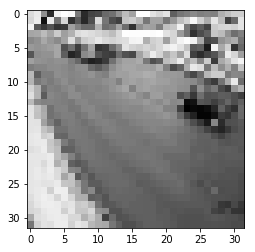

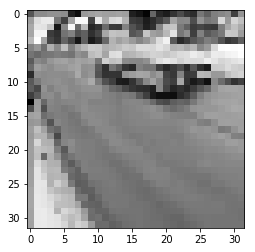

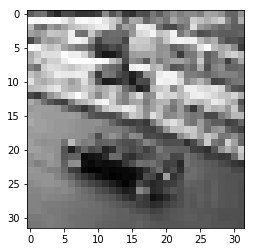

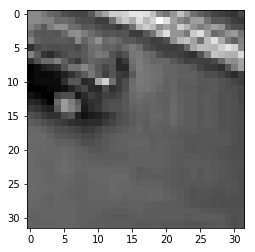

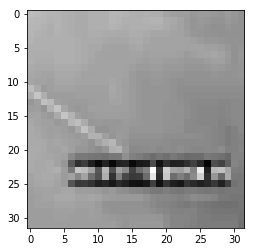

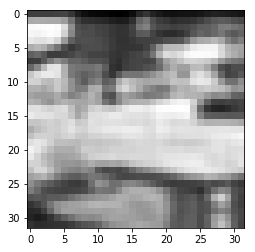

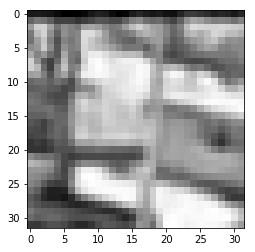

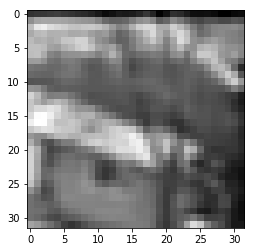

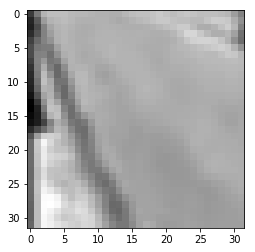

In [13]:
win, coo = get_windows(images[0])
win = np.array(win)
win = win.reshape(-1,32,32)
for window in win:
    clone = images[0].copy()
    if(eval_window(window))!='background':
        plt.figure()
        plt.imshow(window, cmap = 'gray')

(50, 32, 32)
(50, 4)
[  0 285   0 285]
[  0 142   0 142]
[  0 142 171 313]
[ 76 171 228 323]
[152 247 228 323]
[  0  47  57 104]
[  0  47 228 275]
[  0  47 285 332]
[38 85  0 47]


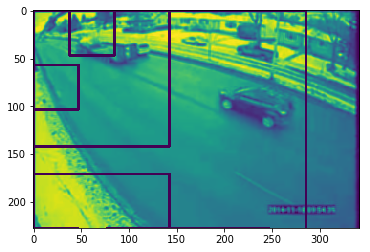

In [27]:
win, coo = get_windows(images[0])
win = np.array(win)
win = win.reshape(-1,32,32)
coo = np.array(coo)
coo = coo.reshape(win.shape[0],-1)
# print(xi, xf, yi, yf)
print(win.shape)
print(coo.shape)
clone = images[0].copy()
for i, window in enumerate (win):
    if(eval_window(window))!='background':
        xi, xf, yi, yf = coo[i]
        print(coo[i])
        clone = cv2.rectangle(clone, (xi, yi), (xf, yf), (0, 0, 0), 2)
plt.imshow(clone)
plt.show()

In [94]:
def getRectIntersectPts(r1, r2):
    min_x = max(r1[0], r2[0])
    max_x = min(r1[2], r2[2])
    min_y = max(r1[3], r2[3])
    max_y = min(r1[1], r2[1])

    return min_x, max_x, min_y, max_y


def calculateDICE(gt, predict):
    if gt[0] > predict[2] or gt[2] < predict[0]:
        return None
    elif gt[1] > predict[3] or gt[3] < predict[1]:
        return None
    else:
        intersect = getRectIntersectPts(gt, predict)
        TP = (intersect[2]-intersect[0])*(intersect[1]-intersect[3])
        gt_area = (gt[2]-gt[0])*(gt[3]-gt[1])
        predict_area = (predict[2]-predict[0])*(predict[3]-predict[1])
        
        DICE = 2*TP/(gt_area+predict_area)
        return DICE

# pass in the g_train row and return the coord
def getCoord(row):
    return [int(row[2]), int(row[3]), int(row[4]), int(row[5])]


In [99]:
with open('./MIO-TCD-Localization/gt_train.csv') as gt_train:
    data = csv.reader(gt_train, delimiter=' ', quotechar='|')
    gt_data = []
    for i, row in enumerate(data):
        gt_data.append(row[0].split(','))


gt_pts = []
# get the rows for the first image
for point in gt_data:
    # this will change when iterated through all images we compare with
    if int(point[0]) == 0:
        gt_pts.append(point)
        
dice = []
for co in coo:
    for point in gt_pts:
        row = getCoord(point)
        dice_val = calculateDICE(row, co)
        if dice_val is not None:
            dice.append(dice_val)
    
print(dice)

print(coo[18])
print(gt_data[3])

gt_coords = [int(gt_data[3][2]), int(gt_data[3][3]), int(gt_data[3][4]), int(gt_data[3][5])]
print(gt_coords)

p1 = [120, 40, 180, 70]
p2 = [140, 65, 200, 85]
# print(calculateDICE(gt_coords, coo[18]))
print(calculateDICE(p1, p2))


[-0.6978002163721602, -0.7466054694970358, -1.3237179487179487, -0.941673873354473, -0.45685202066241265, -0.5287053732419762, -0.7222592839670892, -0.6422457477074862, -0.7364257800970473, -0.583522624842257, -0.6140084899939358, -0.834612700628053]
[  0  47 228 275]
['00000000', 'articulated_truck', '43', '25', '109', '55']
[43, 25, 109, 55]
5.133333333333334


In [18]:
def test_case(num):
    plt.figure()
    win, coo = get_windows(images[num])
    win = np.array(win)
    win = win.reshape(-1,32,32)
    coo = np.array(coo)
    coo = coo.reshape(win.shape[0],-1)
    clone = images[num].copy()
    for i, window in enumerate (win):
        if(eval_window(window))!='background':
            xi, xf, yi, yf = coo[i]
            clone = cv2.rectangle(clone, (xi, yi), (xf, yf), (0, 0, 0), 2)
    plt.imshow(clone)
    plt.show()

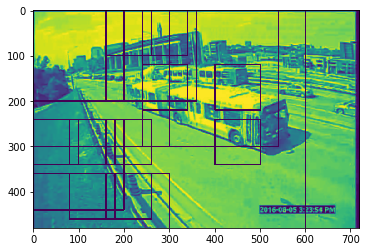

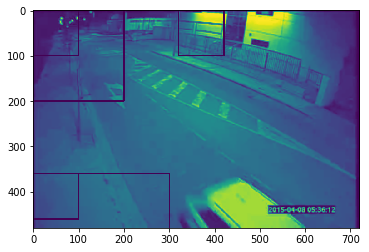

In [19]:
for i in range(1,3):
    test_case(i)

In [25]:
print(coo.shape)

(50, 4)
